Notebook by Paul Scotti with code adapted from 
Aidan Dempster (https://github.com/Veldrovive/open_clip)

In particular, please somebody try out the various networks Aidan shared (https://github.com/Veldrovive/open_clip/blob/main/src/open_clip/model.py) which includes more complex architectures like transformers and architectures that handle both 2D and 3D voxels.

I also have a DistributedDataParallel version of this notebook for anyone who might want to use this with multi-gpu on Slurm (just ask me for it).

## jimgoo

Done:
- Normalize targets after clamping, normalize network outputs in training and validation sets. Helps to overfit to the first training batch.
- Simpler network arch, original wasn't able to overfit to one batch.
- Turn off LR decay, shuffling, data aug

Todo:
- [x] Swap CLIP version L/14 to B/32 and see if results are still good. (Makes no diff, still around 32% top 1.)
- [ ] Run CLIP image ResNet and CLIP text
- [x] Try with and without data aug. With aug causes network NaN preds after a couple epochs.

In [1]:
!nvidia-smi

Fri Nov 18 16:49:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   30C    P5    40W / 300W |      2MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Parameters

In [43]:
# model_name = 'clip_image_vit' # CLIP ViT-L/14 image embeddings
# model_name = 'clip_text_vit' # CLIP ViT-L/14 text embeddings
model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

# clip_vit_version = "ViT-L/14" # vec dim = 768
clip_vit_version = 'ViT-B/32' # vec dim = 512

use_img_aug = False # whether or not to use image augmentation for CLIP ViT models (resnet will never use aug)

In [47]:
print(f"Using model: {model_name}")

Using model: clip_image_resnet


## Import packages & functions

In [48]:
# You will need to download files from huggingface and change the respective paths to those files
# https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main

In [49]:
#!pip install "git+https://github.com/openai/CLIP.git@main#egg=clip"
#!pip install git+https://github.com/openai/CLIP.git

In [50]:
#!pip install info-nce-pytorch

In [51]:
import os
import sys
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import time
from collections import OrderedDict
from glob import glob
from PIL import Image

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mean = np.array([0.48145466, 0.4578275, 0.40821073])
std = np.array([0.26862954, 0.26130258, 0.27577711])
denorm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))

def torch_to_Image(x,device=device):
    x = denorm(x)
    return transforms.ToPILImage()(x)

def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5

def pairwise_cosine_similarity(A, B, dim=1, eps=1e-8):
    #https://stackoverflow.com/questions/67199317/pytorch-cosine-similarity-nxn-elements
    numerator = A @ B.T
    A_l2 = torch.mul(A, A).sum(axis=dim)
    B_l2 = torch.mul(B, B).sum(axis=dim)
    denominator = torch.max(torch.sqrt(torch.outer(A_l2, B_l2)), torch.tensor(eps))
    return torch.div(numerator, denominator)

def batchwise_cosine_similarity(Z, B):
    # https://www.h4pz.co/blog/2021/4/2/batch-cosine-similarity-in-pytorch-or-numpy-jax-cupy-etc
    B = B.T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity

def get_non_diagonals(a):
    a = torch.triu(a,diagonal=1)+torch.tril(a,diagonal=-1)
    # make diagonals -1
    a=a.fill_diagonal_(-1)
    return a

def topk(similarities,labels,k=5):
    if k > similarities.shape[0]:
        k = similarities.shape[0]
    topsum=0
    for i in range(k):
        topsum += torch.sum(torch.argsort(similarities, axis=1)[:,-(i+1)] == labels)/len(labels)
    return topsum

def get_preprocs():
    preproc_vox = transforms.Compose([transforms.ToTensor(), torch.nan_to_num])
    preproc_img = transforms.Compose([
                        transforms.Resize(size=(224,224)),
                        transforms.Normalize(mean=mean,
                                             std=std),
                    ])
    return preproc_vox, preproc_img

cuda


## Which pretrained model are you using for voxel alignment to embedding space? 

In [53]:
if model_name=='clip_image_vit':
    model, preprocess = clip.load(clip_vit_version, device=device)
    emb_name = "images"
elif model_name=='clip_text_vit':
    model, preprocess = clip.load(clip_vit_version, device=device)
    emb_name = "trial"
elif model_name=='clip_image_resnet':
    model, preprocess = clip.load("RN50", device=device)
    emb_name = "images"
    
# dont want to train model
model.eval()

# dont need to calculate gradients
for param in model.parameters():
    param.requires_grad = False

if model_name == 'clip_text_vit':
    f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
    subj01_order = f['subj01'][:]
    f.close()

    # curated the COCO annotations in the same way as the mind_reader (Lin Sprague Singh) preprint
    annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
    subj01_annots = annots[subj01_order]
    
    def text_tokenize(annots):
        for i,b in enumerate(annots):
            t = ''
            while t == '':
                rand = torch.randint(5,(1,1))[0][0]
                t = b[0,rand]
            if i==0:
                txt = np.array(t)
            else:
                txt = np.vstack((txt,t))
        txt = txt.flatten()
        return clip.tokenize(txt)
    
    def embedder(text_token):
        with torch.no_grad():
            text_features = model.encode_text(text_token.to(device))
        return text_features
else:
    def embedder(image):
        with torch.no_grad():
            image_features = model.encode_image(image.to(device))
            if "vit" in model_name: # I think this is the clamping used by Lin Sprague Singh preprint
                image_features = torch.clamp(image_features, -1.5, 1.5)
                # normalize after clipping per the paper
                image_features = nn.functional.normalize(image_features, dim=-1)
        return image_features
    
#print(model)

## Load data

NSD webdatasets for subjects 1, 2, and 3 are publicly available here: 

https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset

In [54]:
# use large batches and the complete training dataset? 
full_training = True
print('full_training', full_training)

full_training True


In [55]:
# NAT_SCENE = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/"
NAT_SCENE = "/home/jimgoo/data/neuro/naturalscenesdataset/webdataset/"

# the tar files have a slightly different format
if "/scratch/gpfs/KNORMAN" in NAT_SCENE:
    SUBJ_FORMAT = "train_subj01_{{{}..{}}}.tar"    
    SUBJ_FORMAT_VAL = "val_subj01_0.tar"
    VOXELS_KEY = 'nsdgeneral.npy'
else:
    SUBJ_FORMAT = "subj01_nsdgeneral_{{{}..{}}}.tar"
    SUBJ_FORMAT_VAL = "val_subj01_nsdgeneral_0.tar"
    VOXELS_KEY = 'voxel.npy'

In [56]:
## things in one sample of data:
# sample00000.voxel.npy
# sample00000.voxel_3d.npy
# sample00000.trial.npy
# sample00000.sgxl_emb.npy
# sample00000.jpg

preproc_vox, preproc_img = get_preprocs()

if use_img_aug:
    ## NOTE: no augmentation is used with resnet!

    # image augmentation just for the CLIP image model that will be more semantic-focused
    img_augment = transforms.Compose([
                        transforms.RandomCrop(size=(140,140)),
                        transforms.Resize(size=(224,224)),
                        transforms.RandomHorizontalFlip(p=.5),
                        transforms.ColorJitter(.4,.4,.2,.1),
                        transforms.RandomGrayscale(p=.2),
                    ])
else:
    img_augment = transforms.Compose([
                        transforms.Resize(size=(224,224)),
                    ])

if not full_training: 
    num_devices = 1
    num_workers = 4
    print("num_workers", num_workers)
    batch_size = 16
    print("batch_size", batch_size)
    num_samples = 500 
    global_batch_size = batch_size * num_devices
    print("global_batch_size", global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches", num_worker_batches)
    train_url = os.path.join(NAT_SCENE, "train", SUBJ_FORMAT.format(0, 1))
    
else:
    # num_devices = torch.cuda.device_count()
    num_devices = 1
    print("WARNING: num_devices hardcoded")
    print("num_devices", num_devices)
    # num_workers = num_devices * 4
    num_workers = 1 # <TODO> switch back the above
    print("WARNING num_workers hardcoded")
    print("num_workers", num_workers)
    batch_size = 300
    # batch_size = 1
    # print("WARNING tiny batch size")
    
    print("batch_size",batch_size)
    num_samples = 24983 # see metadata.json in webdataset_split folder
    global_batch_size = batch_size * num_devices
    print("global_batch_size", global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches", num_worker_batches)
    train_url = os.path.join(NAT_SCENE, "train", SUBJ_FORMAT.format(0, 49))

train_data = wds.DataPipeline([
                    # wds.ResampledShards(train_url), # <TODO> switch back to this once I understand it
                    wds.SimpleShardList(train_url),
                    wds.tarfile_to_samples(),
                    # wds.shuffle(500, initial=500), # <TODO> this seems hardcoded for `full_training=False`
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels=VOXELS_KEY, embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name),
                    wds.batched(batch_size, partial=True),
                ]) #.with_epoch(num_worker_batches) # <TODO> add this back

train_dl = wds.WebLoader(train_data, num_workers=num_workers,
                         batch_size=None, shuffle=False, persistent_workers=True)

# Validation #
num_samples = 492
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches", num_worker_batches)

url = os.path.join(NAT_SCENE, "val", SUBJ_FORMAT_VAL)

val_data = wds.DataPipeline([
                    # wds.ResampledShards(url), # <TODO> switch back to this once I understand it
                    wds.SimpleShardList(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels=VOXELS_KEY, embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name),
                    wds.batched(batch_size, partial=True),
                ])#.with_epoch(num_worker_batches) # <TODO> add this back

val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

num_devices 1
WARNING num_workers hardcoded
num_workers 1
batch_size 300
global_batch_size 300
num_worker_batches 83
validation: num_worker_batches 2


In [57]:
def test_loader(dl):
    # run through one batch and verify things are working
    for i, (voxel, emb) in enumerate(dl):
        print("idx", i)
        print("voxel.shape", voxel.shape)
        print("emb.shape", emb.shape)
        
        if emb_name=='images': # image embedding
            emb = emb.to(device)
        else: # text embedding
            text_tokens = text_tokenize(subj01_annots[emb]).to(device)
        
        emb = embedder(emb)
        print("emb.shape2", emb.shape)
        out_dim = emb.shape[1]
        print("out_dim", out_dim)
        break
    return out_dim

In [58]:
out_dim = test_loader(train_dl)

idx 0
voxel.shape torch.Size([300, 15724])
emb.shape torch.Size([300, 3, 224, 224])
emb.shape2 torch.Size([300, 1024])
out_dim 1024


In [59]:
out_dim = test_loader(val_dl)

idx 0
voxel.shape torch.Size([300, 15724])
emb.shape torch.Size([300, 3, 224, 224])
emb.shape2 torch.Size([300, 1024])
out_dim 1024


In [63]:
# t0 = time.time()
# n_batches = 0
# for train_i, (voxel0, emb0) in enumerate(train_dl):
#     n_batches += 1
# t1 = time.time()

# # 84, 233.06136536598206
# n_batches, t1-t0

In [61]:
# t0 = time.time()
# n_batches = 0
# for val_i, (val_voxel0, val_emb0) in enumerate(val_dl):
#     n_batches += 1
# t1 = time.time()

# # (492, 3.9010021686553955)
# n_batches, t1-t0

In [19]:
# get the first batch of everything
for train_i, (voxel0, emb0) in enumerate(train_dl):
    break

for val_i, (val_voxel0, val_emb0) in enumerate(val_dl):
    break

In [20]:
voxel0.shape, val_voxel0.shape

(torch.Size([300, 15724]), torch.Size([300, 15724]))

In [21]:
emb0.shape, val_emb0.shape

(torch.Size([300, 3, 224, 224]), torch.Size([300, 3, 224, 224]))

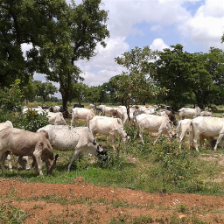

In [22]:
torch_to_Image(emb0[0])

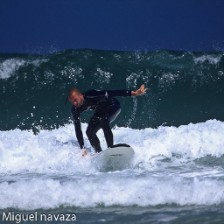

In [23]:
torch_to_Image(val_emb0[0])

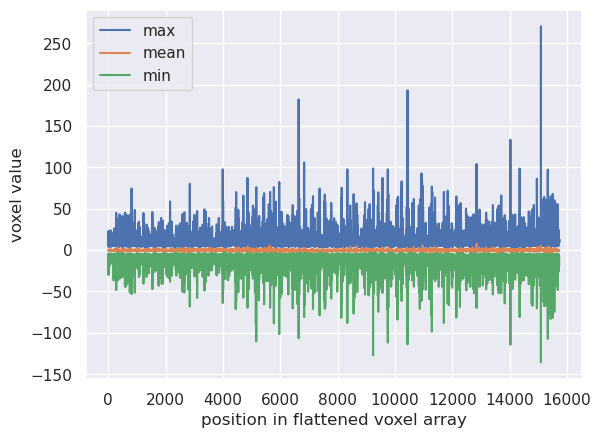

In [24]:
# <TODO> scale the voxels once I understand more about the format of trials inside the tar dataset files
V = voxel0.cpu().numpy()
plt.plot(np.vstack((np.max(V, 0), np.mean(V, 0), np.min(V, 0))).T);
plt.legend(['max', 'mean', 'min']);
plt.xlabel('position in flattened voxel array');
plt.ylabel('voxel value');

## Initialize network

In [25]:
class BrainNetwork(nn.Module):
    def __init__(self, out_dim, h=7861):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.Dropout1d(0.1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lin = nn.Linear(h, h)
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(251552, out_dim)
        
    def forward(self, x):
        #import ipdb; ipdb.set_trace()
        # [300, 15724] -> [300, 1, 15724]
        x = x[:, None, :]
        
        # [300, 1, 15724] -> [300, 32, 7861]
        x = self.conv(x)
        residual = x
        for res_block in range(4):
            # same output shape
            x = self.lin(x)
            x += residual
            x = self.relu(x)
            residual = x
        # [300, 32, 7861] -> [300, 251552]
        x = x.reshape(len(x), -1)
        x = self.lin1(x)
        return x
## 254,996,014 params

# PS note: i also tried the below network and it didn't work nearly as good at the top one
# class BrainNetwork(nn.Module):
#     def __init__(self, out_dim, h=5120):
#         super().__init__()
#         self.blocks = 4
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=0),
#             nn.Dropout1d(0.1),
#             nn.ReLU(),
#             nn.AdaptiveMaxPool1d(h)
#         )
#         self.lin = [nn.Linear(h,h).to(device) for blocks in range(self.blocks)]
#         self.drop = nn.Dropout1d(0.1)
#         self.norm = [nn.BatchNorm1d(32).to(device) for blocks in range(self.blocks)]
#         self.relu = [nn.ReLU() for blocks in range(self.blocks)]
#         self.lin1 = nn.Linear(163840,out_dim)
        
#     def forward(self, x):
#         x = x[:,None,:]
#         x = self.conv(x)
#         residual = x
#         for res_block in range(self.blocks):
#             x = self.lin[res_block](x)
#             x = self.drop(x)
#             x = self.norm[res_block](x)
#             x = self.relu[res_block](x)
#             x = residual + x
#             residual = x
#         x = x.reshape(len(x),-1)
#         x = self.lin1(x)
#         return x 

# class BrainNetwork(nn.Module):
#     def __init__(self,
#                  out_dim,
#                  input_size=15724,
#                  h1=4096,
#                  h2=2048,
#                  h3=1024,
#                  pdrop=0.1,
#     ):
#         super().__init__()
        
#         self.mlp = nn.Sequential(
#             #torch.nn.BatchNorm1d(input_size),
#             nn.Linear(input_size, h1),
#             nn.ReLU(),
#             nn.Dropout(pdrop),
#             nn.Linear(h1, h2),
#             nn.ReLU(),
#             nn.Dropout(pdrop),
#             nn.Linear(h2, h3),
#             nn.ReLU(),
#             nn.Dropout(pdrop),
#             nn.Linear(h3, out_dim),
#         )
        
#     def forward(self, x):
#         return self.mlp(x)

def param_count(model):
    """number of params in model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
# brain_net_orig = BrainNetwork(out_dim)
# print("{:,} params".format(param_count(brain_net_orig)))

In [27]:
# reset rng seed
torch.manual_seed(123)
np.random.seed(123)

# init model
brain_net = BrainNetwork(out_dim)

# input_size = 15724
# h1 = 4096
# h2 = 2048
# h3 = 1024
# pdrop = 0.1

# brain_net = nn.Sequential(
#     #torch.nn.BatchNorm1d(input_size),
#     nn.Linear(input_size, h1),
#     nn.ReLU(),
#     nn.Linear(h1, h2),
#     nn.ReLU(),
#     nn.Linear(h2, h3),
#     nn.ReLU(),
#     nn.Linear(h3, out_dim),
# )
# brain_net = nn.Sequential(
#     #torch.nn.BatchNorm1d(input_size),
#     nn.Linear(input_size, h1),
#     nn.ReLU(),
#     nn.Dropout(pdrop),
#     nn.Linear(h1, h2),
#     nn.ReLU(),
#     nn.Dropout(pdrop),
#     nn.Linear(h2, h3),
#     nn.ReLU(),
#     nn.Dropout(pdrop),
#     nn.Linear(h3, out_dim),
# )

print("{:,} params".format(param_count(brain_net)))
brain_net

319,393,582 params


BrainNetwork(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): Dropout1d(p=0.1, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin): Linear(in_features=7861, out_features=7861, bias=True)
  (relu): ReLU()
  (lin1): Linear(in_features=251552, out_features=1024, bias=True)
)

In [28]:
brain_net = brain_net.to(device)

# test out that the neural network can run without error:
with torch.cuda.amp.autocast():
    out = brain_net(voxel0.to(device))
    print(out.shape)

torch.Size([300, 1024])


## Train model

In [29]:
if full_training:
    # num_epochs = 100
    num_epochs = 10
else:
    num_epochs = 20
    
#initial_learning_rate = 1e-6
initial_learning_rate = 3e-4
# initial_learning_rate = 0.01
#initial_learning_rate = 3e-3
#print("WARNING - large learning rate", initial_learning_rate)

optimizer = torch.optim.Adam(brain_net.parameters(), lr=initial_learning_rate)
# optimizer = torch.optim.SGD(brain_net.parameters(), lr=initial_learning_rate, momentum=0.95)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-8, patience=5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

loss_fun = InfoNCE() # what we will use for loss function  
# loss_fun = nn.MSELoss()
#loss_fun = nn.MSELoss()

# Other losses to consider: #
# Cosine Similarity:
# # full pairwise matrix approach:
# logits = pairwise_cosine_similarity(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
# labels = torch.arange(len(emb)).to(device)
# cos_loss = nn.functional.cross_entropy(logits, labels)
# # or more direct approach without full pairwise matrix
# cos = nn.CosineSimilarity()
# cos_loss = torch.mean(1-cos(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1)))
# # MSE Loss:
# mse = nn.MSELoss()
# mse_loss = mse(emb_,emb)

In [30]:
def plot_training():
    print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17,3))
    ax1.set_title(f"Training Loss\n(final={train_losses[-1]})")
    ax1.plot(train_losses)
    ax2.set_title(f"Training Performance\n(final={train_percent_correct[-1]})")
    ax2.plot(train_percent_correct)
    ax3.set_title(f"Val Loss\n(final={val_losses[-1]})")
    ax3.plot(val_losses)
    ax4.set_title(f"Val Performance\n(final={val_percent_correct[-1]})")
    ax4.plot(val_percent_correct)
    plt.show()
    
def plot_preds(y, y_hat, title='', outdir=''):
    true = y.cpu().detach().numpy().T
    pred = y_hat.cpu().detach().numpy().T
    
    for i in range(y.shape[0]):
        plt.plot(np.vstack((true[:,i], pred[:,i])).T);
        plt.legend(['true', 'pred']);
        plt.title(title + ' sample %i' % i)
        if outdir:
            if not os.path.exists(outdir):
                os.makedirs(outdir)
            plt.savefig(outdir + '/%s-preds-sample-%i.jpeg' % (title, i))
            plt.close()
        else:
            plt.show()
        
def plot_err(y, y_hat, title=''):
    err = (y - y_hat)
    err = err.cpu().detach().numpy()
    plt.plot(err.T)
    plt.title(title)
    plt.show();    
    
class AverageMeter:
    def __init__(self, name=None):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = self.count = self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count   
        
def save_ckpt(path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': brain_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_percent_correct': train_percent_correct,
            'val_percent_correct': val_percent_correct,
            'lrs': lrs,
            'clip_vit_version': clip_vit_version,
    }, path)

In [31]:
outdir = './checkpoints/v04-B32-resnet-orig-network'

In [32]:
!rm -rf $outdir/

In [33]:
!mkdir -p $outdir
!mkdir -p $outdir/preds/train/
!mkdir -p $outdir/preds/val/
!mkdir -p $outdir/ckpts/

In [34]:
!tree $outdir/

./checkpoints/v04-B32-resnet-orig-network/
├── ckpts
└── preds
    ├── train
    └── val

4 directories, 0 files


In [35]:
print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(f"Will be saving model checkpoints to checkpoints/{model_name}_subj01_epoch#.pth")

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

epoch = 0
train_losses = []; val_losses = []
train_percent_correct = []
val_percent_correct = []
lrs = []
epoch_logs = []

# # resuming from checkpoint?
# ckpt_path = f'checkpoints/{model_name}_subj01_epoch20.pth'
# checkpoint = torch.load(ckpt_path, map_location=device)
# epoch=checkpoint['epoch']+1
# brain_net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# train_losses=checkpoint['train_losses']
# train_percent_correct=checkpoint['train_percent_correct']
# val_losses=checkpoint['val_losses']
# val_percent_correct=checkpoint['val_percent_correct']
# lrs=checkpoint['lrs']

# bs = 300

num_epochs:10 batch_size:300 lr:0.0003
2022-11-18 16:49:44
Will be saving model checkpoints to checkpoints/clip_image_resnet_subj01_epoch#.pth


In [38]:
img_augment

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
)

In [39]:
emb.shape

torch.Size([300, 1024])

In [41]:
model_name, emb_name

('clip_image_resnet', 'images')

In [36]:
pbar = tqdm(range(epoch, num_epochs))
for epoch in pbar:
    
    brain_net.train()
    
    train_loss_avg = AverageMeter()
    train_topk_avg = AverageMeter()
    val_loss_avg = AverageMeter()
    val_topk_avg = AverageMeter()

    for train_i, (voxel, emb) in enumerate(train_dl):
    #for train_i, (voxel, emb) in enumerate([(voxel0[:bs], emb0[:bs])]):
        
        bsz = voxel.shape[0]

        voxel = voxel.to(device)

        with torch.cuda.amp.autocast():
            if emb_name=='images': # image embedding
                if "resnet" in model_name:
                    emb = embedder(emb.to(device))
                else: # image augmentations for semantic-focused image model
                    emb = embedder(img_augment(emb.to(device)))
            else: # text embedding
                text_tokens = text_tokenize(subj01_annots[emb]).to(device)
                emb = embedder(text_tokens)

            emb_ = brain_net(voxel)
            if torch.any(torch.isnan(emb_)):
                raise ValueError("NaN found...")
            emb_ = nn.functional.normalize(emb_, dim=-1) # l2 normalization on the embeddings

            labels = torch.arange(bsz).to(device)
            loss = loss_fun(emb_.reshape(bsz, -1), emb.reshape(bsz, -1))

            similarities = batchwise_cosine_similarity(emb, emb_)

            percent_correct = topk(similarities, labels, k=1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_percent_correct.append(percent_correct.item())
        
        train_loss_avg.update(loss.detach_(), bsz)
        train_topk_avg.update(percent_correct.detach_(), bsz)
        
        if train_i == 0 and epoch % 5 == 0:
            # plot_preds(emb[:2], emb_[:2], 'train', outdir + '/preds/epoch-%03d' % epoch)
            torch.save((emb_[:2], emb[:2]), outdir + '/preds/train/epoch-%03d.to' % epoch)
        
    brain_net.eval()    
    
    # using all validation samples to compute loss
    for val_i, (val_voxel, val_emb) in enumerate(val_dl):
    #for val_i, (val_voxel, val_emb) in enumerate([(val_voxel0[:bs], val_emb0[:bs])]):
        
        bsz = val_voxel.shape[0]

        with torch.no_grad(): 
            val_voxel = val_voxel.to(device)

            with torch.cuda.amp.autocast():
                if emb_name=='images': # image embedding
                    val_emb = embedder(val_emb.to(device)) 
                else: # text embedding
                    val_text_tokens = text_tokenize(subj01_annots[val_emb]).to(device)
                    val_emb = embedder(val_text_tokens)

                val_emb_ = brain_net(val_voxel)
                val_emb_ = nn.functional.normalize(val_emb_, dim=-1) # l2 normalization on the embeddings

                labels = torch.arange(bsz).to(device)
                val_loss = loss_fun(val_emb_.reshape(bsz,-1), val_emb.reshape(bsz,-1))

                val_similarities = batchwise_cosine_similarity(val_emb, val_emb_)

                percent_correct = topk(val_similarities, labels, k=1)

            val_losses.append(val_loss.item())
            val_percent_correct.append(percent_correct.item())
            
            val_loss_avg.update(val_loss.detach_(), bsz)
            val_topk_avg.update(percent_correct.detach_(), bsz)
            
            if val_i == 0 and epoch % 5 == 0:
                # plot_preds(val_emb[:2], val_emb_[:2], 'val', outdir + '/preds/epoch-%03d' % epoch)
                torch.save((val_emb_[:2], val_emb[:2]), outdir + '/preds/val/epoch-%03d.to' % epoch)

    if (epoch % 10 == 0 or epoch == num_epochs - 1) and full_training:
        ckpt_path = f'{outdir}/ckpts/{model_name}_subj01_epoch{epoch}.pth'
        save_ckpt(ckpt_path)
    
    # <TODO> add back LR decay
    # scheduler.step(val_loss)
    
    lrs.append(optimizer.param_groups[0]['lr'])
    
    #pbar.set_description(f"Loss: {np.median(train_losses[-(train_i+1):]):.3f} 
    #" | VLoss: {np.median(val_losses[-(val_i+1):]):.3f} "
    #" | TopK%: {np.median(train_percent_correct[-10:]):.3f} 
    #" | VTopK%: {np.median(val_percent_correct[-10:]):.3f} | lr{lrs[-1]:.5f}")
    
    logs = OrderedDict(
        loss=train_loss_avg.avg.item(),
        topk=train_topk_avg.avg.item(),
        val_loss=val_loss_avg.avg.item(),
        val_topk=val_topk_avg.avg.item(),
        lr=lrs[-1],
    )
    epoch_logs.append(logs)
    pbar.set_postfix(**logs)
    pd.DataFrame(epoch_logs).to_csv(outdir + '/epoch-logs.csv')
    
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

  0%|                                                                                                                                                                                         | 0/10 [00:26<?, ?it/s]


ValueError: NaN found...

In [ ]:
#epoch == num_epochs - 1, full_training

In [ ]:
# if emb_name=='images': # image embedding
#     if "resnet" in model_name:
#         emb = embedder(emb.to(device))
#     else: 
#         # image augmentations for semantic-focused image model
#         emb = embedder(img_augment(emb.to(device)))
# else: # text embedding
#     text_tokens = text_tokenize(subj01_annots[emb]).to(device)
#     emb = embedder(text_tokens)

# emb_ = brain_net(voxel)
# if torch.any(torch.isnan(emb_)):
#     raise ValueError("NaN found...")

In [ ]:
plot_training()

In [ ]:
df = pd.DataFrame(epoch_logs)
df.drop(['lr'], axis=1).plot(subplots=True, layout=((1, df.shape[1])), figsize=(20, 5));
plt.tight_layout();

In [ ]:
df.tail(1)

In [ ]:
df.tail(1).to_markdown()

Training for 10 epochs

|    |    loss |     topk |   val_loss |   val_topk |     lr |
|---:|--------:|---------:|-----------:|-----------:|-------:|
|  CLIP ViT-B/32 image w/o aug | 1.33726 | 0.799023 |    2.95771 |   0.347561 | 0.0003 |
|  CLIP ResNet image w/o aug | 1.56654 | 0.782172 |    2.99042 |   0.306911 | 0.0003 |

## Plot losses from saved model

In [ ]:
def plot_saved(ckpt_path):
    # Loading 
    # ckpt_path = 'checkpoints/clip_image_vit_subj01_epoch20.pth' 
    
    checkpoint = torch.load(ckpt_path, map_location=device)
    print(f"Plotting results from {ckpt_path}")

    train_losses=checkpoint['train_losses']
    train_percent_correct=checkpoint['train_percent_correct']
    val_losses=checkpoint['val_losses']
    val_percent_correct=checkpoint['val_percent_correct']

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17,3))
    ax1.set_title(f"Training Loss\n(final={train_losses[-1]})")
    ax1.plot(train_losses)
    ax2.set_title(f"Training Performance\n(final={train_percent_correct[-1]})")
    ax2.plot(train_percent_correct)
    ax3.set_title(f"Val Loss\n(final={val_losses[-1]})")
    ax3.plot(val_losses)
    ax4.set_title(f"Val Performance\n(final={val_percent_correct[-1]})")
    ax4.plot(val_percent_correct)
    plt.show()

In [ ]:
plot_saved(ckpt_path)

## Evaluating Top-K Image Retrieval

Restart kernel, run "import packages & functions" and "initialize network" cells, and then run below cells.

NOTE: this uses the first batch of the validation set only (but there are only two batches anyway)

In [ ]:
num_samples, batch_size, num_workers, num_worker_batches

In [ ]:
# num_samples = 492
# batch_size = 300
# num_batches = 1
# num_workers = 1
# num_worker_batches = 1

preproc_vox, preproc_img = get_preprocs()

# url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
# val_data = wds.DataPipeline([wds.ResampledShards(url),
#                     wds.tarfile_to_samples(),
#                     wds.decode("torch"),
#                     wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
#                                 embs="sgxl_emb.npy", trial="trial.npy"),
#                     wds.map_dict(images=preproc_img),
#                     wds.to_tuple("voxels", "images", "trial"),
#                     wds.batched(batch_size, partial=True),
#                 ]).with_epoch(num_worker_batches)
# val_dl = wds.WebLoader(val_data, num_workers=num_workers,
#                        batch_size=None, shuffle=False, persistent_workers=True)

url = os.path.join(NAT_SCENE, "val", SUBJ_FORMAT_VAL)

val_data = wds.DataPipeline([
                    # wds.ResampledShards(url), # <TODO> switch back to this once I understand it
                    wds.SimpleShardList(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels=VOXELS_KEY, embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name, "trial"),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(1) #num_worker_batches)

val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

In [ ]:
# clip_model, _ = clip.load(clip_vit_version, device=device)
# # resnet_model, _ = clip.load("RN50", device=device)
# clip_model.eval()
# resnet_model.eval()

# f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
# subj01_order = f['subj01'][:]
# f.close()

# # curated the COCO annotations in the same way as the mind_reader (Lin Sprague Singh) preprint
# annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
# subj01_annots = annots[subj01_order]

# def text_tokenize(annots):
#     for i,b in enumerate(annots):
#         t = ''
#         while t == '':
#             rand = torch.randint(5,(1,1))[0][0]
#             t = b[0,rand]
#         if i==0:
#             txt = np.array(t)
#         else:
#             txt = np.vstack((txt,t))
#     txt = txt.flatten()
#     return clip.tokenize(txt)

# def clip_text_embedder(text_token):
#     with torch.no_grad():
#         text_features = clip_model.encode_text(text_token.to(device))
#     return text_features

# def clip_image_embedder(image):
#     with torch.no_grad():
#         image_features = clip_model.encode_image(image.to(device))
#         image_features = torch.clamp(image_features,-1.5,1.5) 
#     return image_features    

def clip_image_embedder(image):
    assert model_name != 'clip_text_vit', model_name
    return embedder(image)

# def resnet_image_embedder(image):
#     with torch.no_grad():
#         image_features = resnet_model.encode_image(image.to(device))
#     return image_features

In [ ]:
ckpt_path

In [ ]:
brain_net = BrainNetwork(out_dim) 
brain_net_clip_img = brain_net.to(device)
# checkpoint = torch.load('checkpoints/clip_image_vit_subj01_epoch20.pth', map_location=device)
checkpoint = torch.load(ckpt_path, map_location=device)
brain_net_clip_img.load_state_dict(checkpoint['model_state_dict'])
brain_net_clip_img.eval()

# brain_net_clip_text = brain_net.to(device)
# checkpoint = torch.load('checkpoints/clip_text_vit_subj01_epoch20.pth', map_location=device)
# brain_net_clip_text.load_state_dict(checkpoint['model_state_dict'])
# brain_net_clip_text.eval()

# brain_net = BrainNetwork(1024) 
# brain_net_resnet_img = brain_net.to(device)
# checkpoint = torch.load('checkpoints/clip_image_resnet_subj01_epoch42.pth', map_location=device)
# brain_net_resnet_img.load_state_dict(checkpoint['model_state_dict'])
# brain_net_resnet_img.eval()

In [ ]:
minibatch = 10 # using minibatches to be able to run evaluation on weaker gpu
for train_i, (voxel, emb, trial_idx) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            # embt = text_tokenize(subj01_annots[trial_idx]).to(device)
            
            emb0=[]; emb1 = []; emb2 =[]
            for m in np.arange(0,batch_size,minibatch):
                if m==0:
                    emb0 = clip_image_embedder(emb[m:m+minibatch]).detach().cpu()
                    # emb1 = resnet_image_embedder(emb[m:m+minibatch]).detach().cpu()
                    # emb2 = clip_text_embedder(embt[m:m+minibatch]).detach().cpu()
                else:
                    emb0 = torch.vstack((emb0,clip_image_embedder(emb[m:m+minibatch]).detach().cpu()))
                    # emb1 = torch.vstack((emb1,resnet_image_embedder(emb[m:m+minibatch]).detach().cpu()))
                    # emb2 = torch.vstack((emb2,clip_text_embedder(embt[m:m+minibatch]).detach().cpu()))

            emb0 = emb0.to(device)
            # emb1 = emb1.to(device)
            # emb2 = emb2.to(device)
            
            emb_0 = brain_net_clip_img(voxel)
            emb_0 = nn.functional.normalize(emb_0, dim=-1) # <TODO> move into network
            # emb_1 = brain_net_resnet_img(voxel)
            # emb_2 = brain_net_clip_text(voxel)
            
            labels = torch.arange(len(emb0)).to(device)
            similarities0 = batchwise_cosine_similarity(emb0,emb_0)
            # similarities1 = batchwise_cosine_similarity(emb1,emb_1)
            # similarities2 = batchwise_cosine_similarity(emb2,emb_2)
            
            # how to combine the different models?
             #similaritiesx = similarities0/2+similarities1+similarities2/2

            print("CLIP IMG")
            
            percent_correct = topk(similarities0,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities0=np.array(similarities0.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities0[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
#             print("\nRESNET50 IMG")
            
#             percent_correct = topk(similarities1,labels,k=1)
#             print("percent_correct",percent_correct)
            
#             similarities1=np.array(similarities1.detach().cpu())
#             for trial in range(4):
#                 fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
#                 ax[0].imshow(torch_to_Image(emb[trial]))
#                 ax[0].set_title("original\nimage")
#                 ax[0].axis("off")
#                 for attempt in range(5):
#                     which = np.flip(np.argsort(similarities1[trial]))[attempt]
#                     ax[attempt+1].imshow(torch_to_Image(emb[which]))
#                     ax[attempt+1].set_title(f"Top {attempt}")
#                     ax[attempt+1].axis("off")
#                 plt.show()
                
#             print("\nCLIP TEXT")
            
#             percent_correct = topk(similarities2,labels,k=1)
#             print("percent_correct",percent_correct)
            
#             similarities2=np.array(similarities2.detach().cpu())
#             for trial in range(4):
#                 fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
#                 ax[0].imshow(torch_to_Image(emb[trial]))
#                 ax[0].set_title("original\nimage")
#                 ax[0].axis("off")
#                 for attempt in range(5):
#                     which = np.flip(np.argsort(similarities2[trial]))[attempt]
#                     ax[attempt+1].imshow(torch_to_Image(emb[which]))
#                     ax[attempt+1].set_title(f"Top {attempt}")
#                     ax[attempt+1].axis("off")
#                 plt.show()
                
#             print("\nCOMBINED")
            
#             percent_correct = topk(similaritiesx,labels,k=1)
#             print("percent_correct",percent_correct)
            
#             similaritiesx=np.array(similaritiesx.detach().cpu())
#             for trial in range(4):
#                 fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
#                 ax[0].imshow(torch_to_Image(emb[trial]))
#                 ax[0].set_title("original\nimage")
#                 ax[0].axis("off")
#                 for attempt in range(5):
#                     which = np.flip(np.argsort(similaritiesx[trial]))[attempt]
#                     ax[attempt+1].imshow(torch_to_Image(emb[which]))
#                     ax[attempt+1].set_title(f"Top {attempt}")
#                     ax[attempt+1].axis("off")
#                 plt.show()

In [ ]:
!tree $outdir